In [17]:
pip install torchvision

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 393.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.2 MB 819.2 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.2 MB 1.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.2 MB 1.4 MB/s eta 0:00:01
   --------------- ------------------------ 0.4/1.2 MB 1.7 MB/s eta 0:00:01
   ------------------ --------------------- 0.5/1.2 MB 1.8 MB/s eta 0:00:01
   -------------------- ------------------- 0.6/1.2 MB 1.7 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.2 MB 1.7 MB/s eta 0:00:01
   -------------------------- ------------- 0.8/1.2 MB 1.8 MB/s eta 0:00:01
   ----------------------------- ---------- 0.9/1.2 MB 1.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.0/1.2 MB 1.8 MB/s eta 0:00:01
   -------------------

In [51]:
import os
from os import listdir
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [96]:
class dogmuffinDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Ensure image has 3 channels
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_images_labels(path_dogs, path_muffins):
    dog_images = [os.path.join(path_dogs, f) for f in os.listdir(path_dogs) if f.endswith('.jpg')]
    muffin_images = [os.path.join(path_muffins, f) for f in os.listdir(path_muffins) if f.endswith('.jpg')]

    dog_labels = [0] * len(dog_images)
    muffin_labels = [1] * len(muffin_images)

    images = dog_images + muffin_images
    labels = dog_labels + muffin_labels

    return images, labels


class Conv_NN(nn.Module):
    def __init__(self):
        super(Conv_NN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def find_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = find_accuracy(model, test_loader)
        loss_history.append(epoch_loss)
        accuracy_history.append(accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

In [97]:
train_path_dogs = 'train/chihuahua'
train_path_muffins = 'train/muffin'
test_path_dogs = 'test/chihuahua'
test_path_muffins = 'test/muffin'
train_images, train_labels = load_images_labels(train_path_dogs, train_path_muffins)
test_images, test_labels = load_images_labels(test_path_dogs, test_path_muffins)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = dogmuffinDataset(train_images, train_labels, transform=transform)
test_dataset = dogmuffinDataset(test_images, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

model = Conv_NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [98]:
loss_history = []
accuracy_history = []

train_model(model, train_loader, criterion, optimizer, num_epochs=5)

 20%|████████████████▌                                                                  | 1/5 [02:26<09:45, 146.43s/it]

Epoch 1/5, Loss: 0.4926, Accuracy: 0.8733


 40%|█████████████████████████████████▏                                                 | 2/5 [04:51<07:16, 145.39s/it]

Epoch 2/5, Loss: 0.3292, Accuracy: 0.8742


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:46<05:18, 159.13s/it]

Epoch 3/5, Loss: 0.2730, Accuracy: 0.8986


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:22<02:37, 157.91s/it]

Epoch 4/5, Loss: 0.2171, Accuracy: 0.9139


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:53<00:00, 154.68s/it]

Epoch 5/5, Loss: 0.1822, Accuracy: 0.9037


In [99]:
evaluate_model(model, test_loader)

torch.save(model.state_dict(), 'dog_muffin_classifier_3.pth')
print('Model saved to dog_muffin_classifier_3.pth')

Test Accuracy: 0.9037
Model saved to dog_muffin_classifier_3.pth


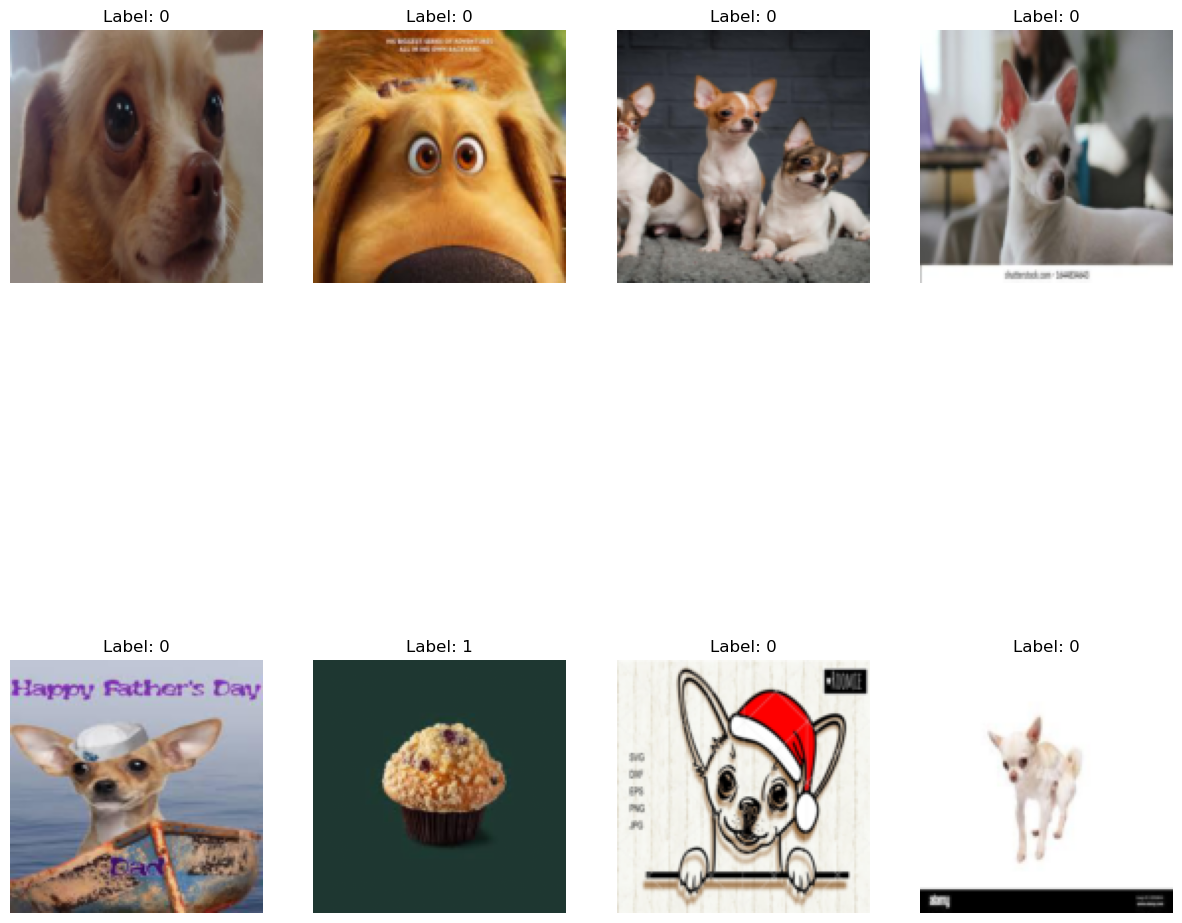

In [135]:
def show_images(images, titles=None):
    n_images = len(images)
    fig, axes = plt.subplots(n_images//4, 4, figsize=(15, 15))
    for i in range(n_images):
        if n_images == 4:
            ax = axes[i%4]
        else:
            ax = axes[i//4][i%4]
        ax.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images[:8], titles=[f"Label: {label}" for label in labels[:8]])

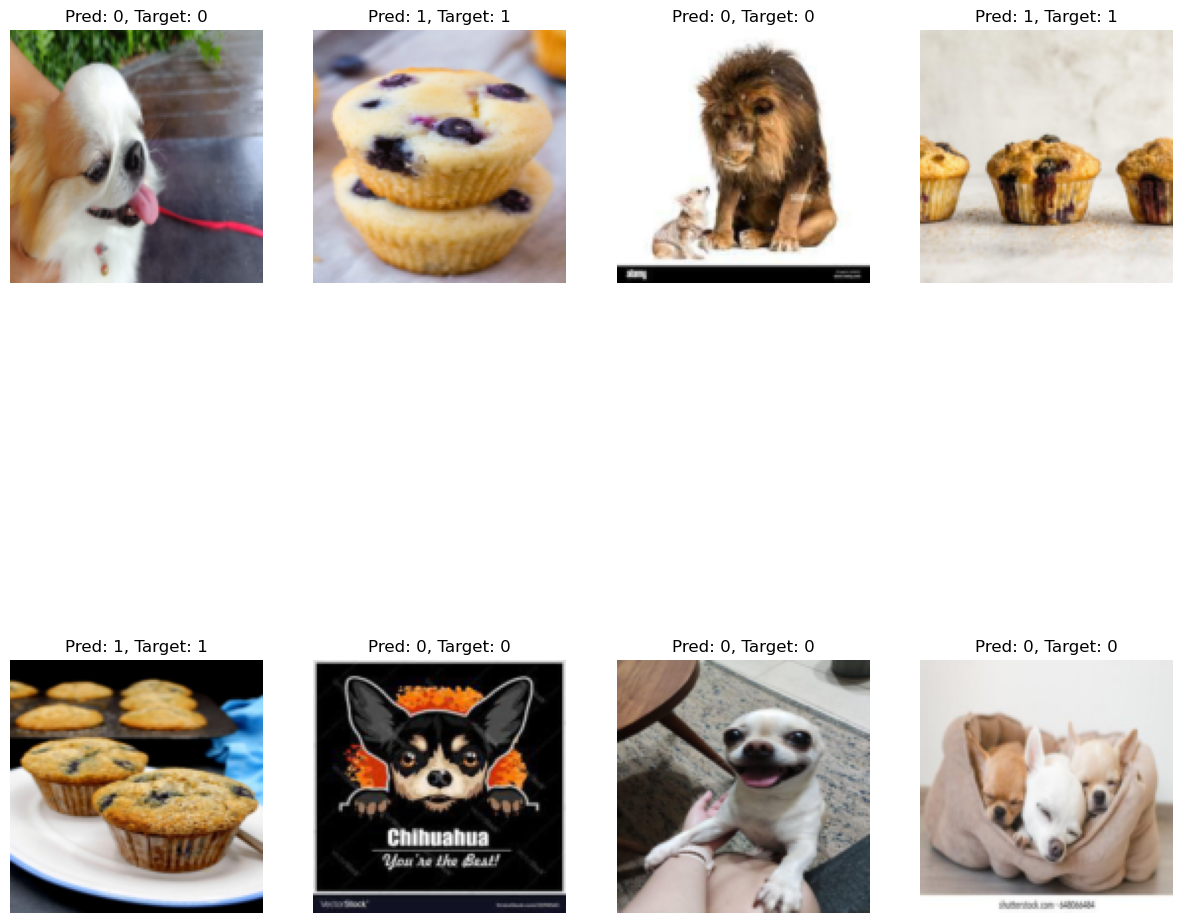

In [182]:
def show_predictions(model, test_loader):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    outputs = model(images)
    _,preds = torch.max(outputs, 1)
    show_images(images[0:8], titles=[f"Pred: {pred}, Target: {label}" for pred, label in zip(preds[0:8], labels[0:8])])

show_predictions(model, train_loader)

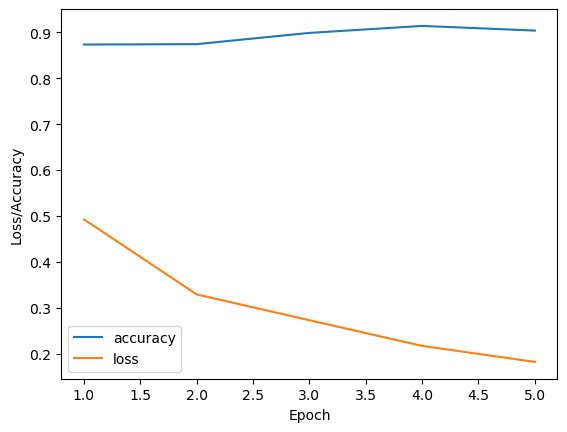

In [167]:
import matplotlib.pyplot as plt

plt.plot([i+1 for i in range(len(loss_history))], accuracy_history, label='accuracy')
plt.plot([i+1 for i in range(len(loss_history))], loss_history, label='loss')
ax = plt.gca()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.legend()
plt.show()

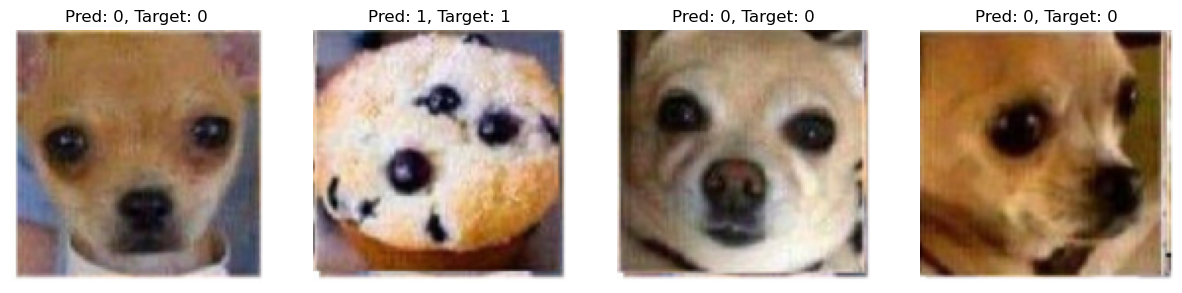

In [192]:
bigtest_path_dogs = 'test/bigtest/chihuahua'
bigtest_path_muffins = 'test/bigtest/muffin'
bigtest_images, bigtest_labels = load_images_labels(bigtest_path_dogs, bigtest_path_muffins)
bigtest_dataset = dogmuffinDataset(bigtest_images, bigtest_labels, transform=transform)
bigtest_loader = DataLoader(bigtest_dataset, batch_size=4, shuffle=True)
dataiter = iter(bigtest_loader)
images, labels = next(dataiter)

show_predictions(model, bigtest_loader)